In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from tensorflow.keras.layers import LSTM, GRU, Dense, Bidirectional

from keras.models import load_model
import keras
import h5py
import requests
import os

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
!pip install pmdarima

<ipython-input-111-4739047f3cbf>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df = pd.read_csv('/content/crude-oil-price.csv')

In [ ]:
df.head()

,date,price,percentChange,change
0,1983-03-30T00:00:00,29.27,NaN,NaN
1,1983-04-04T00:00:00,30.63,4.646396,1.36
2,1983-05-02T00:00:00,30.25,-1.240614,-0.38
3,1983-06-01T00:00:00,31.38,3.735537,1.13
4,1983-07-01T00:00:00,32.00,1.975781,0.62


In [ ]:
df.date = pd.to_datetime(df.date)
df.set_index('date', inplace=True)

In [ ]:
df.head()

,price,percentChange,change
date,,,
1983-03-30,29.27,NaN,NaN
1983-04-04,30.63,4.646396,1.36
1983-05-02,30.25,-1.240614,-0.38
1983-06-01,31.38,3.735537,1.13
1983-07-01,32.00,1.975781,0.62


In [ ]:
df.isnull().sum()

price            0
percentChange    1
change           1
dtype: int64

In [ ]:
df = df.drop('1983-03-30')

In [ ]:
df.isnull().sum()

price            0
percentChange    0
change           0
dtype: int64

In [ ]:
df.head()

,price,percentChange,change
date,,,
1983-04-04,30.63,4.646396,1.36
1983-05-02,30.25,-1.240614,-0.38
1983-06-01,31.38,3.735537,1.13
1983-07-01,32.00,1.975781,0.62
1983-08-01,31.59,-1.281250,-0.41


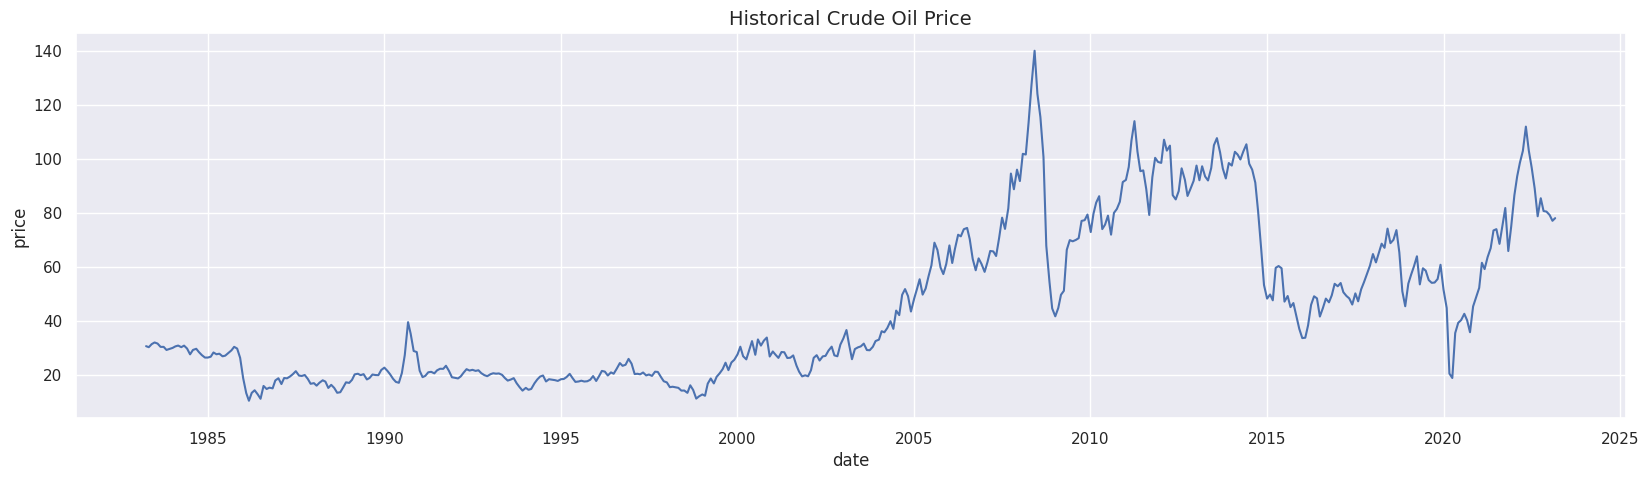

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")
plt.figure(figsize=(20,5))
sns.lineplot(x="date", y="price", data=df)
plt.title('Historical Crude Oil Price', fontsize=14)
plt.show()

In [ ]:
# from scipy import stats
# import numpy as np
# z = np.abs(stats.zscore(df))
# print(z)

# threshold = 3
# ot1 = np.where(z >= threshold)

# print(ot1)

# print("Numbers of rows that are now to be removed: ", len(ot1))

# df = df[(z<3).all(axis=1)]

# df.shape

In [ ]:
# df['ma7'] = df.price.rolling(window=7).mean()
# df['ma21'] = df.price.rolling(window=21).mean()

# # Creating the EMA
# df['ema12'] = df.price.ewm(span=12).mean().fillna(0)
# df['ema26'] = df.price.ewm(span=26).mean().fillna(0)
# df['macd'] = df.ema12 - df.ema26

# #The variables below are used for Bollinger Bands.
# window=21
# no_std = 2
# rolling_mean = df.price.rolling(window).mean()
# rolling_std = df.price.rolling(window).std()
# df['bollinger_low'] = (rolling_mean - (rolling_std * no_std)).fillna(0)
# df['bollinger_high'] = (rolling_mean + (rolling_std * no_std)).fillna(0)
# df['ema'] = df.price.ewm(com=0.5).mean()
# df['momentum'] =  df.price - 1

# df.head()

In [ ]:
scalerz = preprocessing.scaler = StandardScaler()
dataset = scalerz.fit_transform(df.price.values.reshape(-1, 1))

In [ ]:
dataset[0:10]

array([[-0.50438178],
       [-0.51754689],
       [-0.478398  ],
       [-0.45691808],
       [-0.47112254],
       [-0.51373594],
       [-0.51338948],
       [-0.55288482],
       [-0.54006616],
       [-0.52690105]])

In [ ]:
splitz = 0.8
train_size = int(len(dataset) * splitz)
test_size = int(len(dataset) * (1-splitz))
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
f'Dataset size: {len(df)} >> Train length: {len(train)} || Test Length: {len(test)}'

'Dataset size: 480 >> Train length: 384 || Test Length: 96'

In [ ]:
def create_dataset(dataset, look_back=15):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
x_train, y_train = create_dataset(train, look_back=15)
x_test, y_test = create_dataset(test, look_back=15)
f'X_train: {x_train.shape} || \
y_train: {y_train.shape} || \
X_test: {x_test.shape} || \
y_test: {y_test.shape}'

'X_train: (368, 15) || y_train: (368,) || X_test: (80, 15) || y_test: (80,)'

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
f'X_train: {x_train.shape} || \
y_train: {y_train.shape} || \
X_test: {x_test.shape} || \
y_test: {y_test.shape}'

'X_train: (368, 1, 15) || y_train: (368,) || X_test: (80, 1, 15) || y_test: (80,)'

In [ ]:
look_back = 15
#GRU model
gru_model = Sequential()
gru_model.add(GRU(20, input_shape=(1, look_back)))
gru_model.add(Dense(1))
gru_model.compile(loss='mean_squared_error', optimizer='adam')

# Bi-LSTM model
bilstm_model = Sequential()
bilstm_model.add(Bidirectional(LSTM(20, input_shape=(1, look_back))))
bilstm_model.add(Dense(1))
bilstm_model.compile(loss='mean_squared_error', optimizer='adam')

# LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(20, input_shape=(1, look_back)))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')

# multi-layer LSTM model
multilstm_model = Sequential()
# multi_model = np.reshape(multilstm_model, (multilstm_model.shape[0], 1, multilstm_model.shape[1]))
multilstm_model.add(LSTM(20, input_shape=(1, look_back),return_sequences = True))
multilstm_model.add(LSTM(20,return_sequences = True))
multilstm_model.add(LSTM(20))
multilstm_model.add(Dense(1))
multilstm_model.compile(loss='mean_squared_error', optimizer='adam')

# Training
gru_model.fit(x_train, y_train, epochs=20, batch_size=1, verbose=0)
bilstm_model.fit(x_train, y_train, epochs=20, batch_size=1, verbose=0)
lstm_model.fit(x_train, y_train, epochs=20, batch_size=1, verbose=0)
multilstm_model.fit(x_train, y_train, epochs=20, batch_size=1, verbose=0)


In [ ]:
grutrainPredict = gru_model.predict(x_train)
grutestPredict = gru_model.predict(x_test)

# invert predictions
grutrainPredict = scalerz.inverse_transform(grutrainPredict)
trainY = scalerz.inverse_transform([y_train])
grutestPredict = scalerz.inverse_transform(grutestPredict)
testY = scalerz.inverse_transform([y_test])

# calculate root mean squared error, mse, mae, and R2
gru_mse = mean_squared_error(testY[0], grutestPredict)
gru_mae = mean_absolute_error(testY[0], grutestPredict)
trainScore = math.sqrt(mean_squared_error(trainY[0], grutrainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], grutestPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
print("GRU MSE:", gru_mse)
print("GRU MAE:", gru_mae)
print('GRU R2 Score: ', r2_score(testY[0], grutestPredict[:,0]))

3/3 [==============================] - 0s 4ms/step
Train Score: 4.50 RMSE
Test Score: 7.17 RMSE
GRU MSE: 51.33909389550585
GRU MAE: 5.494140423774719
GRU R2 Score:  0.8400528970305777


In [ ]:
bitrainPredict = bilstm_model.predict(x_train)
bitestPredict = bilstm_model.predict(x_test)

# invert predictions
bitrainPredict = scalerz.inverse_transform(bitrainPredict)
trainY = scalerz.inverse_transform([y_train])
bitestPredict = scalerz.inverse_transform(bitestPredict)
testY = scalerz.inverse_transform([y_test])

# calculate root mean squared error
bilstm_mse = mean_squared_error(testY[0], bitestPredict)
bilstm_mae = mean_absolute_error(testY[0], bitestPredict)
trainScore = math.sqrt(mean_squared_error(trainY[0], bitrainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], bitestPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
print("Bi-LSTM MSE:", bilstm_mse)
print("Bi-LSTM MAE:", bilstm_mae)
print('Bi-LSTM R2 Score: ', r2_score(testY[0], bitestPredict[:,0]))

3/3 [==============================] - 0s 6ms/step
Train Score: 4.16 RMSE
Test Score: 6.77 RMSE
Bi-LSTM MSE: 45.899627217400905
Bi-LSTM MAE: 5.081965092658997
Bi-LSTM R2 Score:  0.8569995719881144


In [ ]:
LSTMtrainPredict = lstm_model.predict(x_train)
LSTMtestPredict = lstm_model.predict(x_test)

# invert predictions
LSTMtrainPredict = scalerz.inverse_transform(LSTMtrainPredict)
trainY = scalerz.inverse_transform([y_train])
LSTMtestPredict = scalerz.inverse_transform(LSTMtestPredict)
testY = scalerz.inverse_transform([y_test])

# calculate root mean squared error
lstm_mse = mean_squared_error(testY[0], LSTMtestPredict)
lstm_mae = mean_absolute_error(testY[0], LSTMtestPredict)
trainScore = math.sqrt(mean_squared_error(trainY[0], LSTMtrainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], LSTMtestPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
print("LSTM MSE:", lstm_mse)
print("LSTM MAE:", lstm_mae)
print('LSTM R2 Score: ', r2_score(testY[0], LSTMtestPredict[:,0]))

3/3 [==============================] - 0s 4ms/step
Train Score: 4.80 RMSE
Test Score: 6.62 RMSE
LSTM MSE: 43.85955700100376
LSTM MAE: 4.969374222640991
LSTM R2 Score:  0.8633554169438332


In [ ]:
multiLSTMtrainPredict = multilstm_model.predict(x_train)
multiLSTMtestPredict = multilstm_model.predict(x_test)

# invert predictions
multiLSTMtrainPredict = scalerz.inverse_transform(multiLSTMtrainPredict)
trainY = scalerz.inverse_transform([y_train])
multiLSTMtestPredict = scalerz.inverse_transform(multiLSTMtestPredict)
testY = scalerz.inverse_transform([y_test])

# calculate root mean squared error
multilstm_mse = mean_squared_error(testY[0], multiLSTMtestPredict)
multilstm_mae = mean_absolute_error(testY[0], multiLSTMtestPredict)
trainScore = math.sqrt(mean_squared_error(trainY[0], multiLSTMtrainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], multiLSTMtestPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
print("Multi-LSTM MSE:", multilstm_mse)
print("Multi-LSTM MAE:", multilstm_mae)
print('Multi-LSTM R2 Score: ', r2_score(testY[0], multiLSTMtestPredict[:,0]))

3/3 [==============================] - 0s 4ms/step
Train Score: 4.66 RMSE
Test Score: 7.28 RMSE
Multi-LSTM MSE: 53.029522012525355
Multi-LSTM MAE: 5.3614309558105475
Multi-LSTM R2 Score:  0.834786363097477


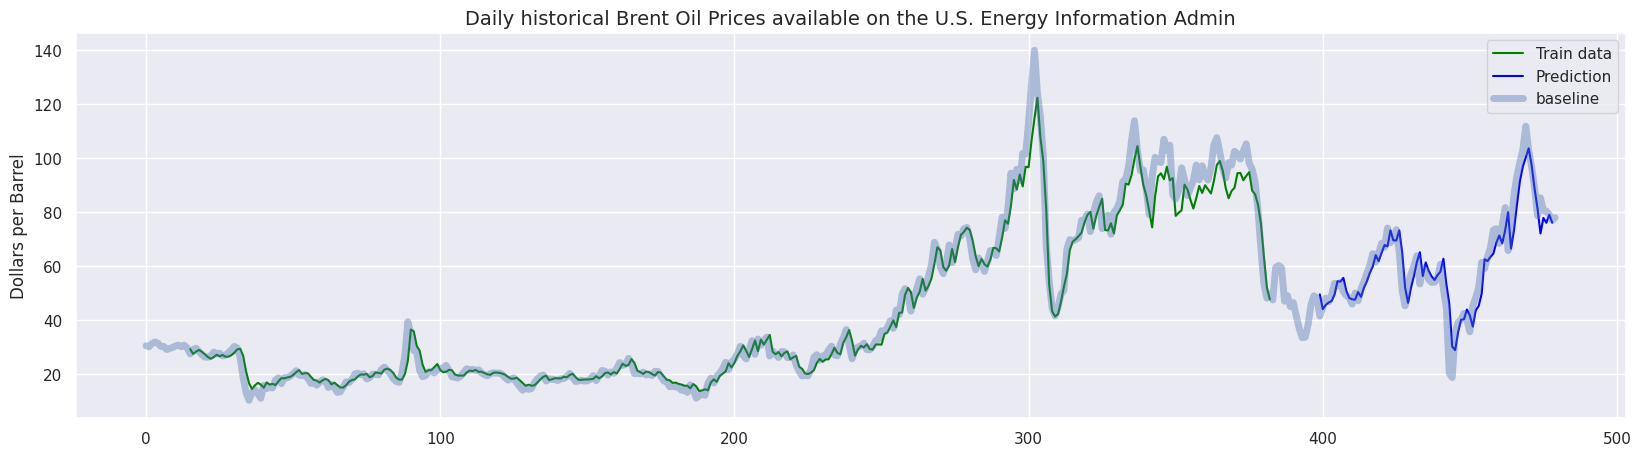

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(LSTMtrainPredict)+look_back, :] = LSTMtrainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(LSTMtrainPredict)+(look_back*2)+1:len(dataset)-1, :] = LSTMtestPredict

# plot baseline and predictions
plt.figure(figsize=(20,5))
plt.plot(trainPredictPlot, color='green', label='Train data')
plt.plot(testPredictPlot, color='blue', label='Prediction',)
plt.plot(scalerz.inverse_transform(dataset),label='baseline', alpha=0.4, linewidth=5)
plt.title('Weekly Crude oil Prices in Dollars with LSTM Model', fontsize=14)
plt.ylabel('Dollars per Barrel')
plt.legend()
plt.show()

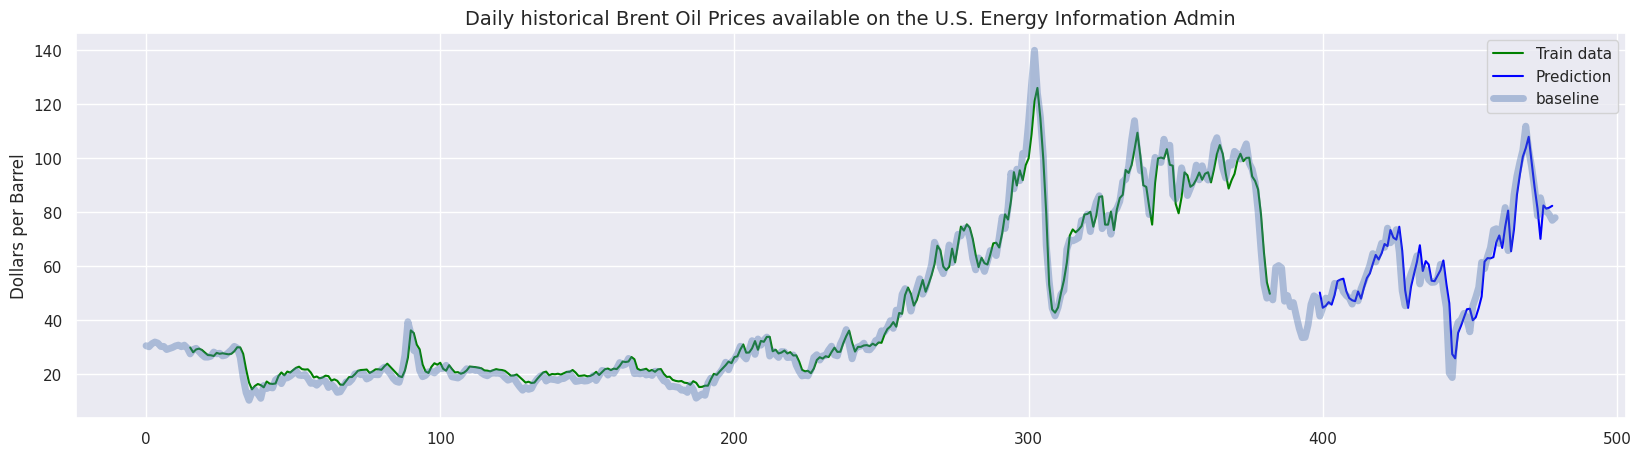

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(bitrainPredict)+look_back, :] = bitrainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(bitrainPredict)+(look_back*2)+1:len(dataset)-1, :] = bitestPredict

# plot baseline and predictions
plt.figure(figsize=(20,5))
plt.plot(trainPredictPlot, color='green', label='Train data')
plt.plot(testPredictPlot, color='blue', label='Prediction',)
plt.plot(scalerz.inverse_transform(dataset),label='baseline', alpha=0.4, linewidth=5)
plt.title('Weekly Crude oil Prices in Dollars with Bi-LSTM Model', fontsize=14)
plt.ylabel('Dollars per Barrel')
plt.legend()
plt.show()

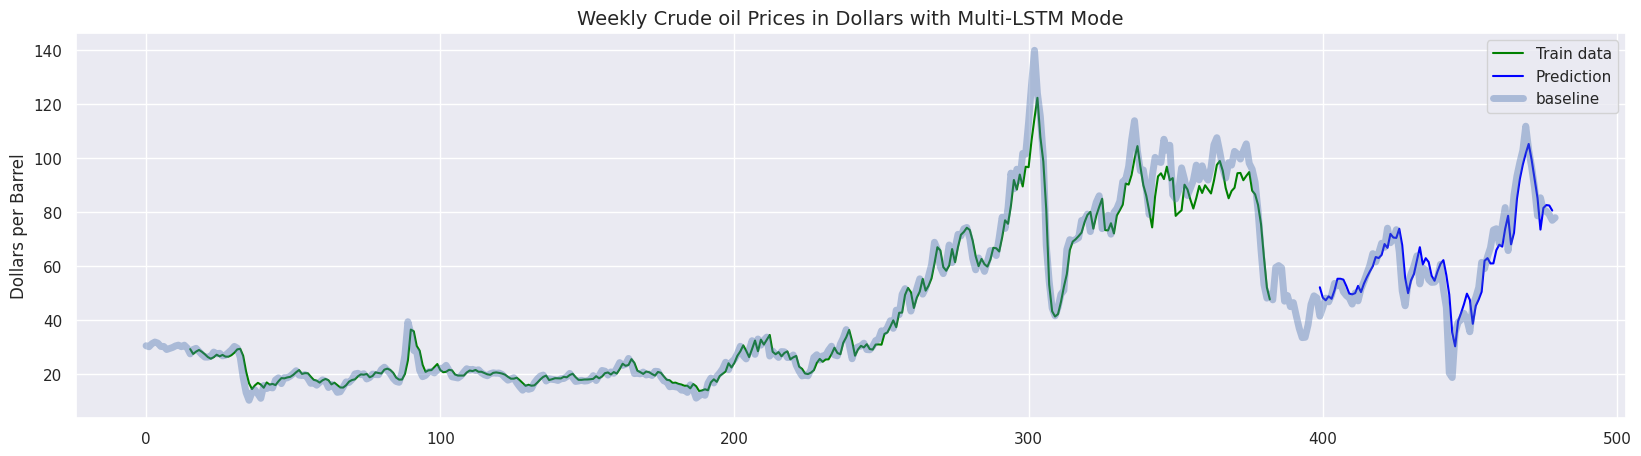

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(LSTMtrainPredict)+look_back, :] = LSTMtrainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(multiLSTMtrainPredict)+(look_back*2)+1:len(dataset)-1, :] = multiLSTMtestPredict

# plot baseline and predictions
plt.figure(figsize=(20,5))
plt.plot(trainPredictPlot, color='green', label='Train data')
plt.plot(testPredictPlot, color='blue', label='Prediction',)
plt.plot(scalerz.inverse_transform(dataset),label='baseline', alpha=0.4, linewidth=5)
plt.title('Weekly Crude oil Prices in Dollars with Multi-LSTM Model', fontsize=14)
plt.ylabel('Dollars per Barrel')
plt.legend()
plt.show()

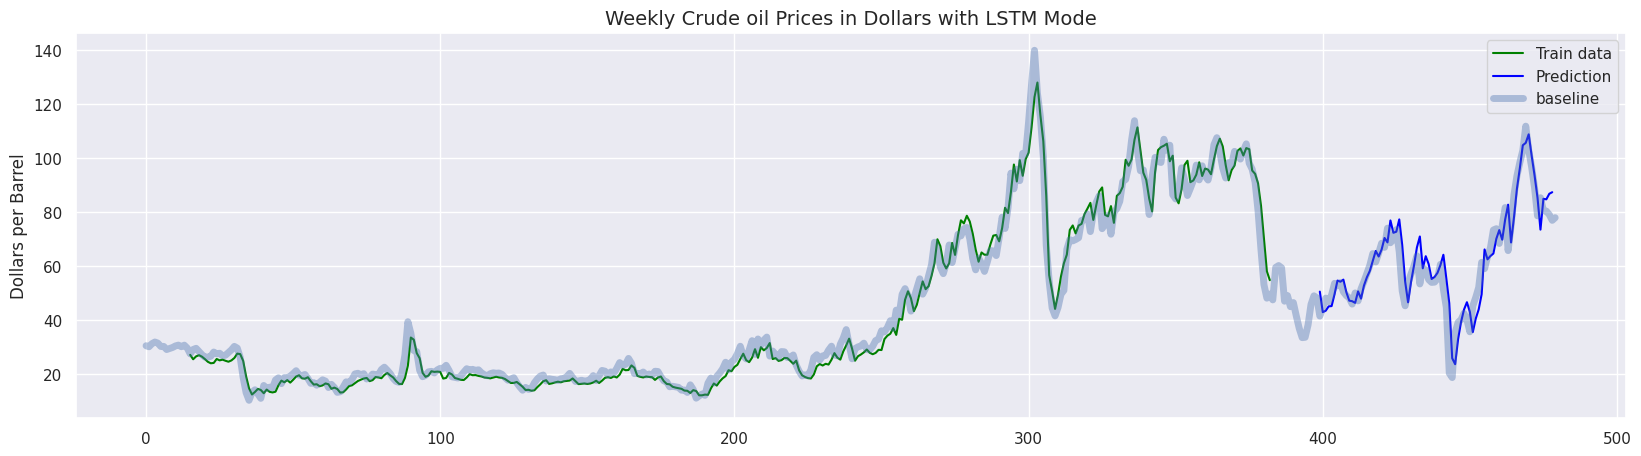

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(grutrainPredict)+look_back, :] = grutrainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(grutrainPredict)+(look_back*2)+1:len(dataset)-1, :] = grutestPredict

# plot baseline and predictions
plt.figure(figsize=(20,5))
plt.plot(trainPredictPlot, color='green', label='Train data')
plt.plot(testPredictPlot, color='blue', label='Prediction',)
plt.plot(scalerz.inverse_transform(dataset),label='baseline', alpha=0.4, linewidth=5)
plt.title('Weekly Crude oil Prices in Dollars with GRU Model', fontsize=14)
plt.ylabel('Dollars per Barrel')
plt.legend()
plt.show()

ARIMA MODEL

In [ ]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df.price.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# H0: Data is non-stationary, H1: Data is stationary
if result[1]<=0.05:
    print("p-value<=0.05: H0 is rejected, data is stationary")
else:
    print("p-value>0.05: H0 is accepted, data is non-stationary")

ADF Statistic: -2.223749
p-value: 0.197739
p-value>0.05: H0 is accepted, data is non-stationary


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import math
data_count = len(df)
train_count = math.ceil(0.8*data_count)
test_count = math.floor(0.2*data_count)
print(train_count, test_count, data_count)

train_data = df["price"].iloc[:train_count]
test_data = df["price"].iloc[train_count:]



384 96 480


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


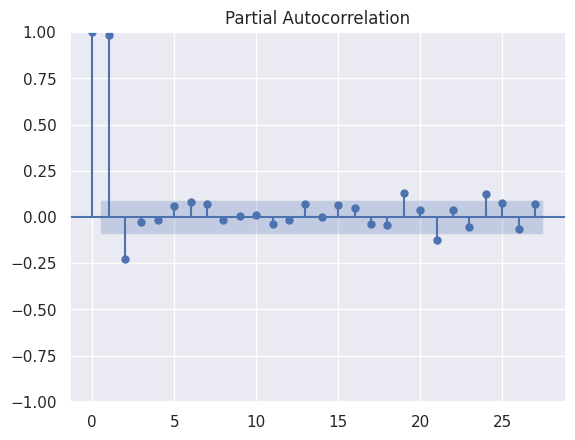

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
plot_pacf(df["price"]);

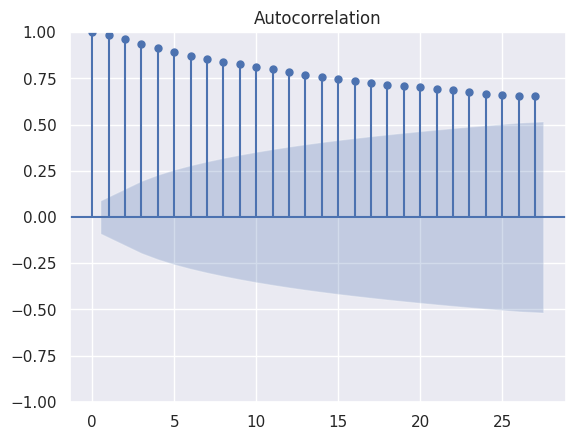

In [ ]:
plot_acf(df["price"]);

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=2249.475, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=2227.456, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=2226.798, Time=0.16 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=2227.565, Time=0.21 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=2226.726, Time=0.35 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=2224.652, Time=0.38 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=2224.358, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=2225.782, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=2227.778, Time=0.38 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=2224.937, Time=0.48 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=2223.177, Time=0.68 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=2225.806, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=2227.776, Time=0.52 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=2229.780, Time=0.59 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=2215.403, Time=2.94 sec
 ARIMA(3,1

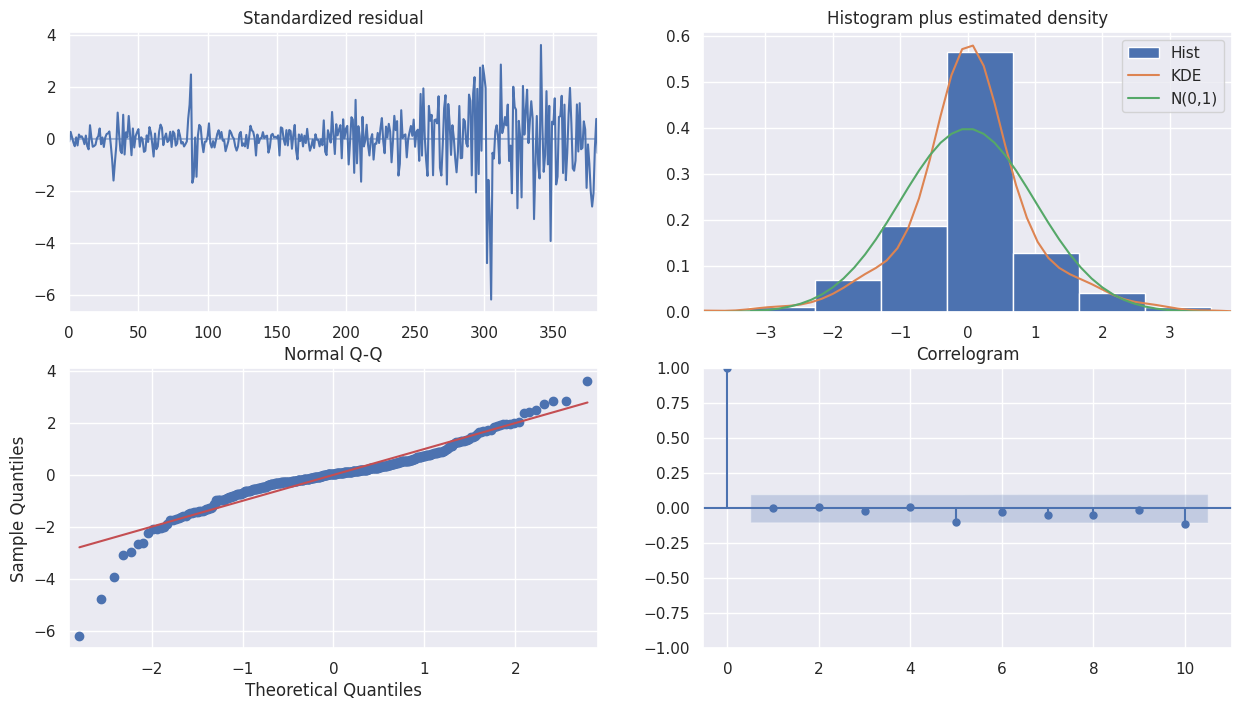

In [ ]:
from pmdarima.arima import auto_arima
model_autoARIMA = auto_arima(train_data,
                      test='adf',
                      m=1,              # frequency of series
                      d=None,
                      seasonal=True,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=False)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [ ]:
model = ARIMA(train_data, order=(2,1,3))
result = model.fit()
print(result.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                  384
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -1100.887
Date:                Mon, 29 May 2023   AIC                           2213.773
Time:                        14:33:42   BIC                           2237.461
Sample:                             0   HQIC                          2223.170
                                - 384                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4082      0.028     51.138      0.000       1.354       1.462
ar.L2         -0.9356      0.025    -36.715      0.000      -0.986      -0.886
ma.L1         -1.1876      0.046    -25.702      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
train_prediction = result.predict(0, train_count)
history = [x for x in train_data]

model_predictions = []
for i in range(test_count):
    model = ARIMA(history, order=(2,1,3))
    model_fit = model.fit()
    output = model_fit.forecast()
    model_predictions.append(output[0])
    history.append(test_data[i])
    print(output[0], test_data[i])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


48.15987236108642 59.63
65.90423868631588 60.3
64.5750037458507 59.47
62.10651245330739 47.12
43.06334183304065 49.2
50.47060877287528 45.09
42.54058236046916 46.59
48.18706091203648 41.65
41.9837206448501 37.04
36.72904442105113 33.62
33.36570161268992 33.75
34.47146636276855 38.34
40.51260566388744 45.92
49.15804969625859 49.1
51.27715312800332 48.33
48.80332907239584 41.6
39.89117967455529 44.7
44.718718041347266 48.24
49.11912454991872 46.86
46.74753178113891 49.44
49.83887314618339 53.72
54.64242939698703 52.81
52.61583314509168 54.01
53.84411077333782 50.6
49.463085669503 49.21
48.276119475750534 48.32
47.71919378096216 46.04
45.353369848620666 50.17
50.9091406195325 47.23
46.939825970279415 51.67
52.50036817210764 54.38
55.2283683834883 57.4
58.13062145697397 60.42
60.96702305483813 64.73
65.357345475374 61.64
60.60524181518384 64.94
64.62707609638038 68.57
68.71315058283584 67.04
66.17675359932244 74.15
74.71705934312774 68.76
67.31565230010472 69.9977
69.02910486133023 73.5992

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


39.983543853048495 39.27


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


42.494378740402304 40.27
41.15943346196414 42.61


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


42.97915416479009 40.22
40.28597043398933 35.79
35.113699044118825 45.34
47.623788838086625 48.52
49.6679142434888 52.2
53.07172454299577 61.5
63.287489527904235 59.16
58.271132739426456 63.58
63.57370248578619 66.93
66.7637015468326 73.47
73.8811908750239 73.95
73.00451095124431 68.5
65.99834212994735 75.03
74.9695737698353 81.78
82.1703847521535 65.85
61.417250630872495 74.88
74.95108652783442 86.49
87.79722465863955 93.5
93.97530502327135 98.52
98.35006112167116 102.94
102.42613758279101 111.91
112.34624608151401 103.1
99.62039160908733 96.75
93.4526550319976 89.03
85.61409320953675 78.72
75.05891823962338 85.4
85.90506403970053 80.66
79.47314219170471 80.45
80.13681614585082 79.17
78.82664404567932 77.05
76.59306457729677 78.0288


In [ ]:
print(df.columns)

Index(['price', 'percentChange', 'change'], dtype='object')


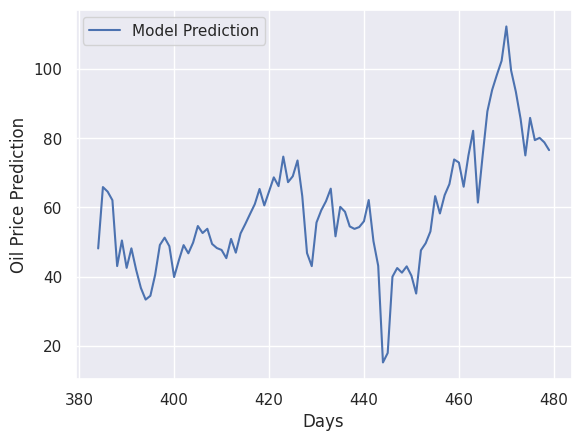

In [ ]:
plt.plot(range(train_count, train_count + test_count), model_predictions, label='Model Prediction')
plt.legend()
plt.xlabel("Days")
plt.ylabel("Oil Price Prediction")
plt.show()

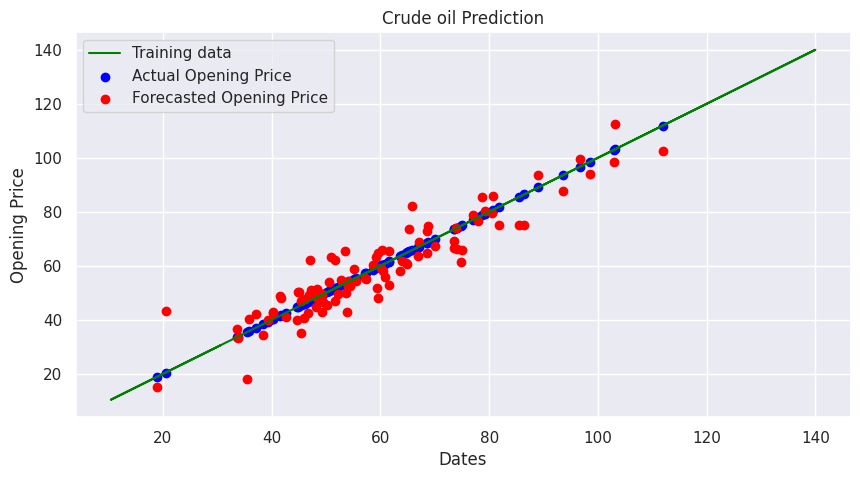

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(df["price"].iloc[:train_count], train_data, color = 'green', label='Training data')
plt.scatter(df["price"].iloc[train_count:], test_data, color = 'blue', label='Actual Opening Price')
plt.scatter(df["price"].iloc[train_count:], model_predictions, color = 'red', label='Forecasted Opening Price')
plt.title('Crude oil Prediction')
plt.xlabel('Dates')
plt.ylabel('Opening Price')
ax = plt.gca()
plt.legend()
plt.show()

In [ ]:
arima_rmse = math.sqrt(mean_squared_error(test_data, model_predictions))
arima_mse = mean_squared_error(test_data, model_predictions)
arima_r2 = r2_score(test_data, model_predictions)
arima_mae = mean_absolute_error(test_data, model_predictions)
# print(test_data, prediction_forecast)
print("RMSE:", arima_rmse)
print("MSE:", arima_mse)
print("R2:", arima_r2)
print("MAE:", arima_mae)

RMSE: 6.540705353614962
MSE: 42.78082652280742
R2: 0.862904589559811
MAE: 5.036481096628618
